In [1]:

#from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
#from credentials import getSecrets  
import pandas as pd
import numpy as np
#import snowflake.connector as sf
import seaborn as sns
import gc


In [2]:
#load order level data of users to calculate score
data=pd.read_csv('user_performance.csv', index_col=0)  # Treats the first column as index
data

,order_id,account_id,event_id,roi,INVESTED_AMOUNT,CREATED_DT,profit,exited_qty,trade_qty
0,1,52,847,-0.710,87.631974,2023-05-13 17:52:14.861755192,-62.218701,5,14
1,2,30,320,3.230,3330.011525,2023-04-30 18:37:05.049358174,10755.937227,0,740
2,3,70,343,0.285,75.829322,2022-12-22 12:58:50.906264693,21.611357,69,151
3,4,54,770,3.610,2764.690002,2022-11-19 17:25:11.487761021,9980.530907,801,2764
4,5,96,161,-0.080,77956.062631,2023-03-21 20:33:09.748030264,-6236.485010,0,9171
...,...,...,...,...,...,...,...,...,...
99995,99996,57,617,-0.060,648.832263,2023-04-04 21:33:59.642456532,-38.929936,661,1297
99996,99997,60,434,8.075,589.631083,2024-11-06 16:00:17.983909458,4761.270997,0,62
99997,99998,16,997,-0.390,1174.887622,2024-02-11 07:42:01.463234782,-458.206172,0,167
99998,99999,59,749,9.120,108.508802,2023-05-13 12:32:30.854234189,989.600277,1,19


# **Dataset Description**

| Column Name       | Description |
|------------------|-------------|
| **order_id**      | Unique ID for every generated order. |
| **account_id**    | Unique identifier for the user placing the order. |
| **event_id**      | Unique identifier for the event associated with the order. |
| **roi**           | Return on Investment for the order. |
| **INVESTED_AMOUNT** | The total amount invested in the order. |
| **CREATED_DT**    | Timestamp when the order was created. |
| **profit**        | Profit earned from the order. |
| **exited_qty**    | The quantity of the order that was exited. |
| **trade_qty**     | The total quantity of trades executed in the order. |


#### Calculating order_ranks and then order level weights

In [5]:

# Rank events within each account_id based on timestamp (descending)
data["order_rank"] = data.groupby("account_id")["CREATED_DT"].rank(method="dense", ascending=False)-1

k2=0.5
k1=0.4

param=float(np.abs(np.log(k2)/k1))


# Compute the max order_ranking for each account_id
data['max_orders'] = data.groupby('account_id')['order_rank'].transform('max')

data['lamda']=param/data['max_orders']
data['weights']=np.exp(-1 * data['lamda'] *  data['order_rank'])
data


,order_id,account_id,event_id,roi,INVESTED_AMOUNT,CREATED_DT,profit,exited_qty,trade_qty,order_rank,max_orders,lamda,weights
0,1,52,847,-0.710,87.631974,2023-05-13 17:52:14.861755192,-62.218701,5,14,623.0,1063.0,0.001630,0.362187
1,2,30,320,3.230,3330.011525,2023-04-30 18:37:05.049358174,10755.937227,0,740,596.0,976.0,0.001775,0.347085
2,3,70,343,0.285,75.829322,2022-12-22 12:58:50.906264693,21.611357,69,151,747.0,1038.0,0.001669,0.287347
3,4,54,770,3.610,2764.690002,2022-11-19 17:25:11.487761021,9980.530907,801,2764,755.0,1019.0,0.001701,0.276949
4,5,96,161,-0.080,77956.062631,2023-03-21 20:33:09.748030264,-6236.485010,0,9171,657.0,1035.0,0.001674,0.332873
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,57,617,-0.060,648.832263,2023-04-04 21:33:59.642456532,-38.929936,661,1297,640.0,990.0,0.001750,0.326202
99996,99997,60,434,8.075,589.631083,2024-11-06 16:00:17.983909458,4761.270997,0,62,88.0,1057.0,0.001639,0.865655
99997,99998,16,997,-0.390,1174.887622,2024-02-11 07:42:01.463234782,-458.206172,0,167,355.0,1004.0,0.001726,0.541876
99998,99999,59,749,9.120,108.508802,2023-05-13 12:32:30.854234189,989.600277,1,19,575.0,959.0,0.001807,0.353809


### Calculation of weighted absolute values 

1. Weights are indicator of recency
2. Above concept used to calculate weighted tot, weighted avg and weighted percentile of params

In [6]:

# Weighted percentile function
def weighted_percentile(data, weights, percentile):
    """Computes the weighted percentile using cumulative sum."""
    sorted_indices = np.argsort(data)  # Sort data
    sorted_data = np.array(data)[sorted_indices]
    sorted_weights = np.array(weights)[sorted_indices]
    
    cum_weights = np.cumsum(sorted_weights) / np.sum(sorted_weights)
    
    return np.interp(percentile / 100.0, cum_weights, sorted_data)

# Aggregation function
def aggregate_weighted_metrics(group):
    total_weight = group['weights'].sum()
    
    return pd.Series({
        'weighted_total_profit': np.sum(group['profit'] * group['weights']) / total_weight,
        'absolute_tot_profit': np.sum(group['profit']),  # Sum of profit without weights
        'weighted_median_profit': weighted_percentile(group['profit'], group['weights'], 50),
        'weighted_25perc_profit': weighted_percentile(group['profit'], group['weights'], 25),
        'weighted_75perc_profit': weighted_percentile(group['profit'], group['weights'], 75),
        'weighted_avg_roi': np.sum(group['roi'] * group['weights']) / total_weight,
        'weighted_median_roi': weighted_percentile(group['roi'], group['weights'], 50),
        'weighted_75perc_roi': weighted_percentile(group['roi'], group['weights'], 75),
        'total_events': group['event_id'].nunique(),
        'total_orders': group['order_id'].count(),
        'exit_rate': group['exited_qty'].sum() / group['trade_qty'].sum() if group['trade_qty'].sum() > 0 else 0
    })

# Aggregating at account_id level
skill_absolute_computation = data.groupby('account_id').apply(aggregate_weighted_metrics).reset_index()

# Display result
skill_absolute_computation


/var/folders/6v/b4z5p7bj0jzd97h8ytt2rkm80000gn/T/ipykernel_79904/3464507196.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  skill_absolute_computation = data.groupby('account_id').apply(aggregate_weighted_metrics).reset_index()


,account_id,weighted_total_profit,absolute_tot_profit,weighted_median_profit,weighted_25perc_profit,weighted_75perc_profit,weighted_avg_roi,weighted_median_roi,weighted_75perc_roi,total_events,total_orders,exit_rate
0,1,1532.390708,1.918193e+06,-1.300116,-51.657548,416.626050,2.047592,-0.030000,4.465000,627.0,1019.0,0.262305
1,2,2074.512560,2.352990e+06,-4.238618,-55.413946,393.291563,1.918332,-0.090000,4.537356,633.0,981.0,0.398875
2,3,2869.227610,3.134072e+06,19.055510,-46.864788,568.645900,2.209955,0.319147,4.940000,633.0,1035.0,0.371405
3,4,2829.955098,2.677514e+06,-0.368210,-50.226912,478.732783,2.165367,-0.010000,5.035000,654.0,1010.0,0.312437
4,5,1766.841703,2.188496e+06,15.510238,-48.090280,556.761970,2.291046,0.380000,5.130000,676.0,1067.0,0.265139
...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,1030.021596,1.233617e+06,-1.844262,-48.728186,458.159100,2.044266,-0.030000,4.370000,638.0,1031.0,0.263651
95,96,1532.327407,1.870101e+06,-4.616926,-51.356131,375.991911,1.939899,-0.060000,4.180000,625.0,1036.0,0.258019
96,97,2213.278476,2.289785e+06,-0.654434,-48.332757,439.256171,2.140523,-0.020000,4.845000,639.0,984.0,0.248950
97,98,1162.921354,1.430114e+06,0.993595,-52.638068,457.092980,2.128564,0.064474,4.845000,642.0,1027.0,0.225295


#### Calculating percentiles for relative scoring over the absolute values

In [7]:
# Function to compute percentile ranks
def add_percentile_columns(df):
    percentile_df = df.copy()
    
    # Compute percentile ranks for all numeric columns except 'account_id'
    for col in df.columns:
        if col != 'account_id':
            percentile_df[f'perc_{col}'] = df[col].rank(pct=True)
    
    return percentile_df

# Compute percentiles
skill_perc_computation = add_percentile_columns(skill_absolute_computation)

# Display result
skill_perc_computation


,account_id,weighted_total_profit,absolute_tot_profit,weighted_median_profit,weighted_25perc_profit,weighted_75perc_profit,weighted_avg_roi,weighted_median_roi,weighted_75perc_roi,total_events,...,perc_absolute_tot_profit,perc_weighted_median_profit,perc_weighted_25perc_profit,perc_weighted_75perc_profit,perc_weighted_avg_roi,perc_weighted_median_roi,perc_weighted_75perc_roi,perc_total_events,perc_total_orders,perc_exit_rate
0,1,1532.390708,1.918193e+06,-1.300116,-51.657548,416.626050,2.047592,-0.030000,4.465000,627.0,...,0.585859,0.404040,0.414141,0.262626,0.414141,0.303030,0.272727,0.358586,0.611111,0.303030
1,2,2074.512560,2.352990e+06,-4.238618,-55.413946,393.291563,1.918332,-0.090000,4.537356,633.0,...,0.787879,0.050505,0.232323,0.151515,0.101010,0.020202,0.343434,0.500000,0.207071,0.929293
2,3,2869.227610,3.134072e+06,19.055510,-46.864788,568.645900,2.209955,0.319147,4.940000,633.0,...,0.969697,0.959596,0.646465,0.969697,0.858586,0.898990,0.813131,0.500000,0.767677,0.858586
3,4,2829.955098,2.677514e+06,-0.368210,-50.226912,478.732783,2.165367,-0.010000,5.035000,654.0,...,0.898990,0.585859,0.505051,0.666667,0.787879,0.560606,0.909091,0.904040,0.505051,0.555556
4,5,1766.841703,2.188496e+06,15.510238,-48.090280,556.761970,2.291046,0.380000,5.130000,676.0,...,0.707071,0.878788,0.575758,0.959596,0.969697,0.919192,0.964646,1.000000,0.939394,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,1030.021596,1.233617e+06,-1.844262,-48.728186,458.159100,2.044266,-0.030000,4.370000,638.0,...,0.080808,0.303030,0.535354,0.535354,0.383838,0.303030,0.202020,0.641414,0.696970,0.323232
95,96,1532.327407,1.870101e+06,-4.616926,-51.356131,375.991911,1.939899,-0.060000,4.180000,625.0,...,0.565657,0.020202,0.444444,0.070707,0.161616,0.116162,0.085859,0.292929,0.787879,0.272727
96,97,2213.278476,2.289785e+06,-0.654434,-48.332757,439.256171,2.140523,-0.020000,4.845000,639.0,...,0.747475,0.505051,0.545455,0.444444,0.747475,0.429293,0.702020,0.681818,0.232323,0.242424
97,98,1162.921354,1.430114e+06,0.993595,-52.638068,457.092980,2.128564,0.064474,4.845000,642.0,...,0.232323,0.707071,0.363636,0.525253,0.666667,0.707071,0.702020,0.737374,0.646465,0.141414


In [9]:
#dictionary containing all weights for aggregating all params
dic_perc_comp={

    'weight_profit_median':0.22,
    'weight_profit_tot':0.43,
    'weight_profit_25_perc':0.17,
    'weight_profit_75_perc':0.18,

    'weight_roi_median':0.3,
    'weight_roi_75_perc':0.3,
    'weight_roi_avg':0.4,

    'slope_sigmoid':13,
    'shift_sigmoid':0.5 }

# dictionary for experience where weights of experience components mentioned
dc_exp={'experience_order_weight':  0.7, 
'experience_event_weight': 0.3}
dc_exp,dic_perc_comp

({'experience_order_weight': 0.7, 'experience_event_weight': 0.3},
 {'weight_profit_median': 0.22,
  'weight_profit_tot': 0.43,
  'weight_profit_25_perc': 0.17,
  'weight_profit_75_perc': 0.18,
  'weight_roi_median': 0.3,
  'weight_roi_75_perc': 0.3,
  'weight_roi_avg': 0.4,
  'slope_sigmoid': 13,
  'shift_sigmoid': 0.5})

In [10]:
reward_factor_experience = 1 / (1 + np.exp(-1 * dic_perc_comp['slope_sigmoid'] * 
                                 (skill_perc_computation['perc_absolute_tot_profit'] - dic_perc_comp['shift_sigmoid'])))

skill_perc_computation['weighted_order']=skill_perc_computation['total_orders'] * reward_factor_experience 

skill_perc_computation['weighted_event']=skill_perc_computation['total_events'] * reward_factor_experience 
skill_perc_computation['net_order']=skill_perc_computation['weighted_order']*dc_exp['experience_order_weight']+skill_perc_computation['weighted_event']*dc_exp['experience_event_weight']
skill_perc_computation['experience'] = skill_perc_computation['net_order'].rank(pct=True)


#### Calculating Final Aggregated components using assigned weights

In [11]:
import pandas as pd

# Dictionary of weightages
dic_perc_comp = {
    'weight_profit_median': 0.22,
    'weight_profit_tot': 0.43,
    'weight_profit_25_perc': 0.17,
    'weight_profit_75_perc': 0.18,
    'weight_roi_median': 0.3,
    'weight_roi_75_perc': 0.3,
    'weight_roi_avg': 0.4
}

# Compute weighted profit component
skill_perc_computation['profit_component'] = (
    dic_perc_comp['weight_profit_median'] * skill_perc_computation['perc_weighted_median_profit'] +
    dic_perc_comp['weight_profit_tot'] * skill_perc_computation['perc_weighted_total_profit'] +
    dic_perc_comp['weight_profit_25_perc'] * skill_perc_computation['perc_weighted_25perc_profit'] +
    dic_perc_comp['weight_profit_75_perc'] * skill_perc_computation['perc_weighted_75perc_profit']
)

# Compute weighted ROI component
skill_perc_computation['roi_component'] = (
    dic_perc_comp['weight_roi_median'] * skill_perc_computation['perc_weighted_median_roi'] +
    dic_perc_comp['weight_roi_75_perc'] * skill_perc_computation['perc_weighted_75perc_roi'] +
    dic_perc_comp['weight_roi_avg'] * skill_perc_computation['perc_weighted_avg_roi']
)
skill_perc_computation['experience_component'] = skill_perc_computation['experience']

skill_perc_computation['exit_component'] = skill_perc_computation['perc_exit_rate']

# Create a new DataFrame with account_id, profit_component, and roi_component
skill_aggregated_components = skill_perc_computation[['account_id', 'profit_component', 'roi_component','exit_component','experience_component']].copy()

# Display new DataFrame
skill_aggregated_components


,account_id,profit_component,roi_component,exit_component,experience_component
0,1,0.345556,0.338384,0.303030,0.585859
1,2,0.386263,0.149495,0.929293,0.767677
2,3,0.890808,0.857071,0.858586,0.959596
3,4,0.725657,0.756061,0.555556,0.929293
4,5,0.672424,0.953030,0.333333,0.878788
...,...,...,...,...,...
94,95,0.275758,0.305051,0.323232,0.080808
95,96,0.227374,0.125253,0.272727,0.575758
96,97,0.622626,0.638384,0.242424,0.737374
97,98,0.355354,0.689394,0.141414,0.232323


#### Calculation of Final skill score

In [12]:
df=skill_aggregated_components.copy()

# Samp

# Define weights in a dictionary
weights = {
    "profit_component": 0.49,
    "roi_component": 0.35,
    "exit_component": 0.07,
    "experience_component": 0.09
}

# Scaling function to scale between 200 and 999
def min_max_scale(series):
    return 200 + ((series - series.min()) / (series.max() - series.min())) * (999 - 200)

# Scale each component
for col in weights.keys():
    df[col + "_scaled"] = min_max_scale(df[col])

# Compute weighted sum
df["skill_score"] = sum(df[col + "_scaled"] * weight for col, weight in weights.items())

# Display the result
df


,account_id,profit_component,roi_component,exit_component,experience_component,profit_component_scaled,roi_component_scaled,exit_component_scaled,experience_component_scaled,skill_score
0,1,0.345556,0.338384,0.303030,0.585859,490.766725,454.928982,436.438776,664.724490,490.076757
1,2,0.386263,0.149495,0.929293,0.767677,528.493380,298.884073,941.928571,811.479592,502.539345
2,3,0.890808,0.857071,0.858586,0.959596,996.097950,883.426632,884.857143,966.387755,946.202214
3,4,0.725657,0.756061,0.555556,0.929293,843.038196,799.980157,640.265306,941.928571,822.673914
4,5,0.672424,0.953030,0.333333,0.878788,793.703339,962.700783,460.897959,901.163265,839.227461
...,...,...,...,...,...,...,...,...,...,...
94,95,0.275758,0.305051,0.323232,0.080808,426.079086,427.391645,452.744898,257.071429,413.194399
95,96,0.227374,0.125253,0.272727,0.575758,381.237727,278.856919,411.979592,656.571429,372.336408
96,97,0.622626,0.638384,0.242424,0.737374,747.551377,702.765013,387.520408,787.020408,710.226194
97,98,0.355354,0.689394,0.141414,0.232323,499.847335,744.905483,305.989796,379.367347,561.204460


In [14]:
final_score=df[['account_id','skill_score']]
final_score

,account_id,skill_score
0,1,490.076757
1,2,502.539345
2,3,946.202214
3,4,822.673914
4,5,839.227461
...,...,...
94,95,413.194399
95,96,372.336408
96,97,710.226194
97,98,561.204460


#### Distribution of Skill Score


/var/folders/6v/b4z5p7bj0jzd97h8ytt2rkm80000gn/T/ipykernel_79904/1834212761.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_score['skill_score'])


<Axes: xlabel='skill_score', ylabel='Density'>

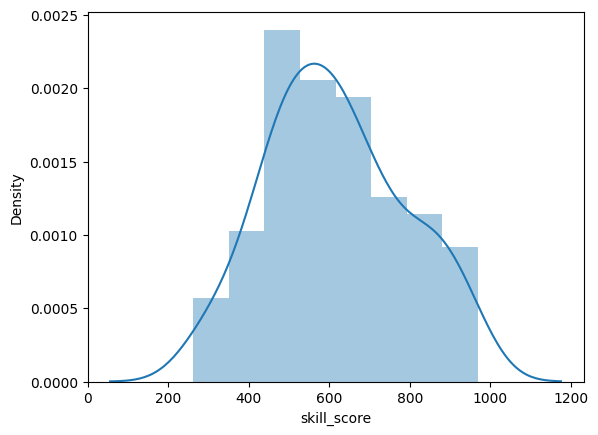

In [17]:
sns.distplot(final_score['skill_score'])


#### Data description of skill score


In [18]:
final_score['skill_score'].describe()

count     99.000000
mean     616.241675
std      172.464002
min      261.800204
25%      500.099312
50%      598.001342
75%      730.566801
max      969.019422
Name: skill_score, dtype: float64